![banner](https://github.com/Arcihugo/Hands-on-Computer-Vision/blob/main/sesiones/sesion3/banner.png?raw=1)

# **Hands-on Sesión 3.1: Deep Learning** 🧠


## **Contenido**

[**1. Perceptron multi-capa**](#tema1)

[**2. Perceptron multi-capa en pytorch**](#tema2)

[**3. Redes Neuronales Convolucionales**](#tema3)


[**4. Preguntas**](#tema7)

In [14]:
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## <font color='#4C5FDA'>**Perceptron multi-capa como aproximador universal** </font> <a name="tema1">

### <font color="EB9A54"> **Generación de datos** </font>

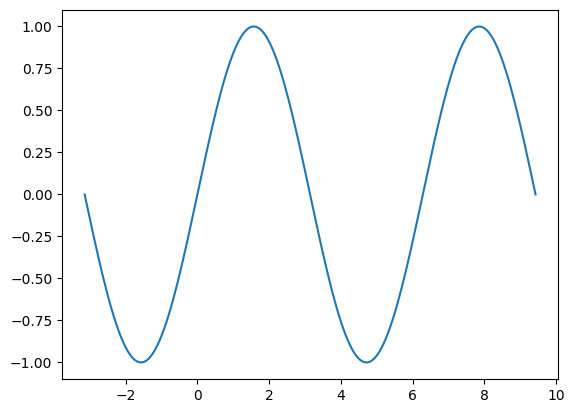

In [15]:
x = np.linspace(-np.pi, 3*np.pi, 200).reshape(-1, 1)
y = np.sin(x)

plt.plot(x, y)

### <font color="4C5FDA"> **Funciones de activación** </font>

La derivdada del tanh crucial para el proceso de backpropagation en redes neuronales, se calcula como $$1 - \tanh^2(x)$$


#### <font color="EB9A54"> **Reto No.1:** </font> Escribe la derivada

In [3]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1-(np.tanh(x))**2)

### <font color="4C5FDA"> **Parametros del perceptron multi-capa** </font>

algunos hiperparametros necesarios de los perceptrones multicapa

In [4]:
# cambialos si quieres mejor convergencia!
input_size = 1
hidden_size = 10
output_size = 1
learning_rate = 0.01
iters = 100000

### <font color="4C5FDA"> **Loss y Inicializacion de pesos** </font>

#### <font color="EB9A54"> **Reto No.2:** </font> Inicializa las matrices de pesos

In [5]:
# Weight initialization
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size,output_size)
b2 = np.zeros((1, output_size))

Se define la derivada de la función de pérdida del error cuadrático medio (MSE) respecto a la predicción como:
$$
    d_{\text{loss}} = \frac{\partial \text{MSE}}{\partial y_{\text{pred}}} = 2 \cdot \frac{y_{\text{pred}} - y}{n}
$$
donde $y$ es el valor real, $y_{\text{pred}}$ es la predicción de la red neuronal, y $n$ es el número de muestras.

#### <font color="EB9A54"> **Reto No.3:** </font> Escribe la derivada del MSE

In [24]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.shape[0]

### <font color="4C5FDA"> **Entrenamiento** </font>

El gradiente de la función de activación en la segunda capa se asigna directamente desde la derivada parcial de la pérdida con respecto a la salida de la capa, es decir:

$$
\frac{\partial L}{\partial z_2} = \frac{\partial L}{\partial \text{loss}} = d_{z2}
$$

El gradiente de los pesos en la segunda capa, $W_2$, se calcula como:

$$
\frac{\partial L}{\partial W_2} = a_1^T \cdot \frac{\partial L}{\partial z_2} = a_1^T \cdot d_{z2}
$$

donde $a_1$ son las activaciones de la primera capa.

El gradiente del sesgo en la segunda capa, $b_2$, se obtiene sumando los gradientes $\frac{\partial L}{\partial z_2}$ a lo largo de la dimensión del batch:

$$
\frac{\partial L}{\partial b_2} = \sum\left(\frac{\partial L}{\partial z_2},\, \text{axis} = 0,\, \text{keepdims} = \text{True}\right) = d_{b_2}
$$

El gradiente de la activación de la primera capa se calcula mediante:

$$
\frac{\partial L}{\partial a_1} = \frac{\partial L}{\partial z_2} \cdot W_2^T = d_{z2} \cdot W_2^T = d_{a_1}
$$

El gradiente de la salida de la primera capa antes de la activación, $z_1$, se calcula multiplicando $\frac{\partial L}{\partial a_1}$ por la derivada parcial de la función de activación tanh con respecto a $z_1$:

$$
\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial a_1} \cdot \frac{\partial a_1}{\partial z_1} = d_{a_1} \cdot \text{tanh'}(z_1) = d_{z1}
$$

donde

$$
\text{tanh'}(z_1) = 1 - \text{tanh}^2(z_1)
$$

El gradiente de los pesos en la primera capa, $W_1$, se calcula como:

$$
\frac{\partial L}{\partial W_1} = x^T \cdot \frac{\partial L}{\partial z_1} = x^T \cdot d_{z1}
$$

donde $x$ representa las entradas al modelo.

Finalmente, el gradiente del sesgo en la primera capa, $b_1$, se obtiene sumando $\frac{\partial L}{\partial z_1}$ a lo largo de la dimensión del batch:

$$
\frac{\partial L}{\partial b_1} = \sum\left(\frac{\partial L}{\partial z_1},\, \text{axis} = 0\right) = d_{b_1}
$$


#### <font color="EB9A54"> **Reto No.4:** </font> Completa el bucle de entrenamiento

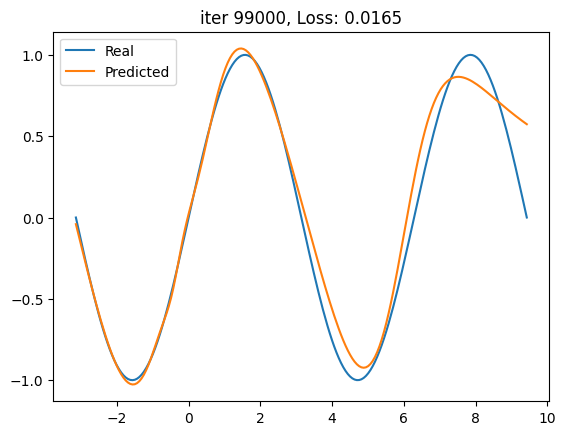

In [25]:

# Training loop
for iter in range(iters):

    # *********************
    # FORWARD PASS
    # *********************
    z1 = np.dot(x, W1) + b1
    a1 = tanh(z1)
    z2 = np.dot(a1, W2) + b2
    y_pred = z2

    # ********************
    # LOSS CALCULATION
    # ********************
    loss = mse_loss(y, y_pred)

    # *********************
    # BACKWARD PASS
    # *********************
    # Corrected d_loss calculation to ensure it returns an array of the correct shape
    d_loss = mse_loss_derivative(y, y_pred)
    d_z2 = d_loss
    d_W2 = np.dot(a1.T, d_z2)
    d_b2 = np.sum(d_z2, axis=0, keepdims=True)
    d_a1 = np.dot(d_z2, W2.T)
    d_z1 = d_a1 * tanh_derivative(z1)
    d_W1 = np.dot(x.T, d_z1)
    d_b1 = np.sum(d_z1, axis=0, keepdims=True) # Added keepdims=True for consistency with b1 shape

    # ********************
    # WEIGHT UPDATES
    # ********************
    W1 -= learning_rate * d_W1
    b1 -= learning_rate * d_b1
    W2 -= learning_rate * d_W2
    b2 -= learning_rate * d_b2


    # ********************
    # PLOT PREDICTIONS
    # ********************
    # dont touch this
    if iter % 1000 == 0:
        clear_output(wait=True)
        plt.plot(x, y, label='Real')
        plt.plot(x, y_pred, label='Predicted')
        plt.title(f'iter {iter}, Loss: {loss:.4f}')
        plt.legend()
        plt.show()


## <font color='#4C5FDA'>**Perceptron multi-capa como aproximador universal en Pytorch** </font> <a name="tema1">

<img src="https://pytorch.org/assets/images/pytorch-logo.png" width="250">

## ¿Por qué usar PyTorch?

PyTorch se ha establecido como una de las principales bibliotecas para el aprendizaje profundo, ofreciendo una combinación única de flexibilidad, eficiencia y potencia. Aquí hay algunas razones para elegir PyTorch para tus proyectos de IA:

- **Interfaz intuitiva:** Su API es clara y amigable, lo que facilita tanto el aprendizaje para los novatos como la implementación rápida de prototipos para los expertos.
- **Autograd dinámico:** PyTorch maneja las derivadas automáticamente, lo que permite modificaciones más flexibles de los grafos computacionales en tiempo de ejecución.
- **Ecosistema rico:** PyTorch está respaldado por una amplia comunidad de desarrolladores y científicos, ofreciendo una vasta colección de herramientas y bibliotecas complementarias para visión por computadora, procesamiento del lenguaje natural y más.
- **Rendimiento:** Optimizado para tanto CPU como GPU, PyTorch proporciona una eficiencia computacional que acelera el tiempo de entrenamiento de modelos complejos.
- **Adopción en la investigación:** Es ampliamente usado en la academia para la investigación en IA, lo que significa que muchas de las últimas innovaciones están disponibles primero en PyTorch.


### <font color="EB9A54"> **Conversion de los datos a tensores** </font>

In [12]:
x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(x_tensor,y_tensor)
train_loader = DataLoader(train_dataset)

### <font color="EB9A54"> **Perceptron multi-capa en Pytorch** </font>

La clase `SineApproximator` es una subclase de `nn.Module` que se utiliza para aproximar la función seno mediante una red neuronal. La implementación de la red requiere definir la estructura de la misma en el método `__init__`, incluyendo las capas y funciones de activación que se utilizarán.

En este caso, se espera que añadas dos capas lineales (`nn.Linear`) y una capa de activación tanh (`nn.Tanh`) entre ellas. La primera capa lineal debe transformar la entrada de dimensión 1 a una dimensión oculta de 50, y la segunda capa lineal debe transformar la salida de la capa oculta de nuevo a una dimensión 1, que es el tamaño de la salida deseada.

Para completar el código, por favor, consulta la documentación de PyTorch sobre [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) y [`nn.Tanh`](https://pytorch.org/docs/stable/nn.html#torch.nn.Tanh) para entender cómo implementar estas capas correctamente.

Aquí tienes un esqueleto de la clase. Por favor, completa la implementación del método `__init__` con las capas necesarias según la descripción anterior:


#### <font color="EB9A54"> **Reto No.4:** </font> Crea el modelo

In [26]:
class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        self.linear1 = nn.Linear(1, 50)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)

        # agrega mas capas si quieres!

        return x

In [28]:
# Función para graficar, just ignore this
def plot_predictions(model, x, y, epoch):
    clear_output(wait=True)
    model.eval()
    with torch.no_grad():
        predictions = model(x_tensor).numpy()
    plt.plot(x, y, label='Original sin(x)')
    plt.plot(x, predictions, label='Approximated sin(x) at Epoch {}'.format(epoch+1))
    plt.legend()
    plt.title(f'Epoch {epoch+1}')
    plt.show()
    model.train()

### <font color="EB9A54"> **Bucle de entrenamiento en pytorch** </font>

Para entrenar el modelo de aproximación de la función seno con PyTorch, necesitarás completar varios pasos clave en el proceso de entrenamiento. Este proceso involucra la inicialización del modelo, la definición del criterio de pérdida, y la implementación del paso de optimización que ajusta los parámetros del modelo basándose en el gradiente de la pérdida.

2. **Definición del Criterio de Pérdida:**  PyTorch ofrece diferentes funciones de pérdida en su módulo `torch.nn`, incluido el MSE. Revisa la [documentación sobre funciones de pérdida](https://pytorch.org/docs/stable/nn.html#loss-functions)

3. **Optimización:**  La [documentación sobre optimizadores](https://pytorch.org/docs/stable/optim.html) proporciona una visión general de cómo se utilizan estos optimizadores.

4. **Backpropagation y Paso de Optimización:** PyTorch automatiza el cálculo del gradiente con `backward()` y el ajuste de los parámetros con `step()`. Para más información, consulta la sección sobre [Autograd: Automatic Differentiation](https://pytorch.org/docs/stable/autograd.html) en la documentación de PyTorch.

Completar estos pasos te permitirá entrenar tu modelo `SineApproximator` para que aprenda a aproximar la función seno. La documentación de PyTorch es un recurso excelente que te guiará a través de estos procesos, asegurando que entiendas cómo implementar correctamente cada componente del entrenamiento.


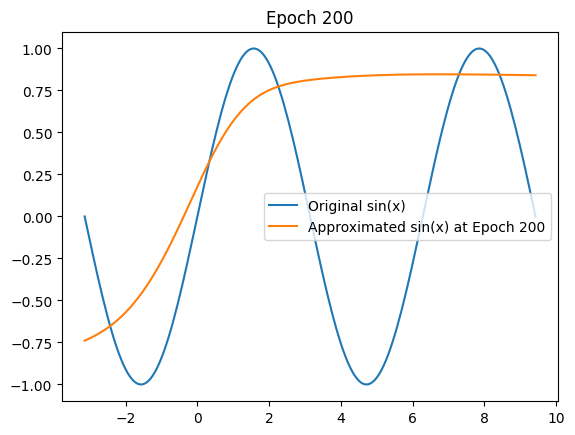

In [32]:
model = SineApproximator()

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 200
plot_every = 10  # dont touch this

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = criterion(output, y_tensor)

    # backward ?
    optimizer.step()

    if (epoch+1) % plot_every == 0:
        plot_predictions(model, x, y, epoch)

plot_predictions(model, x, y, epochs - 1)

## <font color='#4C5FDA'>**Creando nuestro primer modelo de vision por computador** </font> <a name="tema1">

### <font color="EB9A54"> **Cargando el conjunto de datos** </font>

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

### <font color="EB9A54"> **Visualizando el conjunto de datos** </font>

In [42]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    image = imshow(images[idx])
    plt.imshow(image)
    ax.set_title(classes[labels[idx]])

TypeError: 'int' object is not callable

### <font color="EB9A54"> **Perceptron multi-capa para clasificación** </font>

#### <font color="EB9A54"> **Reto No.5:** </font> Crea las capas lineales

In [43]:
class MLP_cifar10(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()

    self.input_layer = nn.Linear(input_dim, hidden_dim)

    self.hidden_layer1 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)

    self.output_layer1 = nn.Linear(hidden_dim,output_dim)

  def forward(self, x):

    # Crea el forward pass de tu red
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_layer1(x))
    x = F.relu(self.hidden_layer2(x))
    x = self.output_layer1(x)


    return F.log_softmax(x, dim=1)

#### <font color="EB9A54"> **Reto No.5:** </font> Agrega el optimizador y la loss del modelo

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_cifar10 = MLP_cifar10(input_dim=3*32*32, hidden_dim=256, output_dim=10).to(device) # Introduce los parametros necesarios para crear tu modelo
optimizer = optim.Adam(model_cifar10.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

parameters = sum(p.numel() for p in model_cifar10.parameters() if p.requires_grad)
print(model_cifar10)
print("Model trainable parameters: ", parameters)

MLP_cifar10(
  (input_layer): Linear(in_features=3072, out_features=256, bias=True)
  (hidden_layer1): Linear(in_features=256, out_features=256, bias=True)
  (hidden_layer2): Linear(in_features=256, out_features=256, bias=True)
  (output_layer1): Linear(in_features=256, out_features=10, bias=True)
)
Model trainable parameters:  920842


#### <font color="EB9A54"> **Reto No.6:** </font> Completa el bucle de entrenamiento

In [46]:
model_cifar10.train()
for epoch in range(epochs):
    avg_loss_epoch = 0
    batch_loss = 0
    total_batches = 0

    for batch_num, batch in enumerate(tqdm(trainloader, desc = f"Epoch {epoch}:")):
        batch = tuple(b.to(device) for b in batch)
        images, labels = batch
        optimizer.zero_grad()

        images = images.reshape(-1, 3*32*32)
        outputs = model_cifar10(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_batches += 1
        batch_loss += loss.item()

    avg_loss_epoch = batch_loss/total_batches
    print ('Epoch [{}/{}], Average Loss for epoch {}: {:.4f}'
                .format(epoch+1, epochs, epoch+1, avg_loss_epoch))

Epoch 0:: 100%|██████████| 782/782 [00:26<00:00, 29.19it/s]


Epoch [1/30], Average Loss for epoch 1: 1.6525


Epoch 1:: 100%|██████████| 782/782 [00:24<00:00, 31.70it/s]


Epoch [2/30], Average Loss for epoch 2: 1.4338


Epoch 2:: 100%|██████████| 782/782 [00:25<00:00, 30.74it/s]


Epoch [3/30], Average Loss for epoch 3: 1.3172


Epoch 3:: 100%|██████████| 782/782 [00:26<00:00, 29.71it/s]


Epoch [4/30], Average Loss for epoch 4: 1.2267


Epoch 4:: 100%|██████████| 782/782 [00:24<00:00, 31.52it/s]


Epoch [5/30], Average Loss for epoch 5: 1.1472


Epoch 5:: 100%|██████████| 782/782 [00:30<00:00, 25.81it/s]


Epoch [6/30], Average Loss for epoch 6: 1.0731


Epoch 6:: 100%|██████████| 782/782 [00:25<00:00, 30.15it/s]


Epoch [7/30], Average Loss for epoch 7: 1.0002


Epoch 7:: 100%|██████████| 782/782 [00:26<00:00, 29.60it/s]


Epoch [8/30], Average Loss for epoch 8: 0.9285


Epoch 8:: 100%|██████████| 782/782 [00:27<00:00, 28.84it/s]


Epoch [9/30], Average Loss for epoch 9: 0.8607


Epoch 9:: 100%|██████████| 782/782 [00:26<00:00, 29.19it/s]


Epoch [10/30], Average Loss for epoch 10: 0.7991


Epoch 10:: 100%|██████████| 782/782 [00:26<00:00, 29.69it/s]


Epoch [11/30], Average Loss for epoch 11: 0.7428


Epoch 11:: 100%|██████████| 782/782 [00:25<00:00, 31.25it/s]


Epoch [12/30], Average Loss for epoch 12: 0.6802


Epoch 12:: 100%|██████████| 782/782 [00:25<00:00, 31.13it/s]


Epoch [13/30], Average Loss for epoch 13: 0.6316


Epoch 13:: 100%|██████████| 782/782 [00:24<00:00, 32.57it/s]


Epoch [14/30], Average Loss for epoch 14: 0.5858


Epoch 14:: 100%|██████████| 782/782 [00:24<00:00, 32.08it/s]


Epoch [15/30], Average Loss for epoch 15: 0.5426


Epoch 15:: 100%|██████████| 782/782 [00:24<00:00, 32.52it/s]


Epoch [16/30], Average Loss for epoch 16: 0.5091


Epoch 16:: 100%|██████████| 782/782 [00:23<00:00, 33.27it/s]


Epoch [17/30], Average Loss for epoch 17: 0.4740


Epoch 17:: 100%|██████████| 782/782 [00:23<00:00, 32.68it/s]


Epoch [18/30], Average Loss for epoch 18: 0.4377


Epoch 18:: 100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [19/30], Average Loss for epoch 19: 0.4217


Epoch 19:: 100%|██████████| 782/782 [00:22<00:00, 34.12it/s]


Epoch [20/30], Average Loss for epoch 20: 0.3968


Epoch 20:: 100%|██████████| 782/782 [00:23<00:00, 33.60it/s]


Epoch [21/30], Average Loss for epoch 21: 0.3731


Epoch 21:: 100%|██████████| 782/782 [00:23<00:00, 33.15it/s]


Epoch [22/30], Average Loss for epoch 22: 0.3526


Epoch 22:: 100%|██████████| 782/782 [00:23<00:00, 32.98it/s]


Epoch [23/30], Average Loss for epoch 23: 0.3341


Epoch 23:: 100%|██████████| 782/782 [00:23<00:00, 33.34it/s]


Epoch [24/30], Average Loss for epoch 24: 0.3407


Epoch 24:: 100%|██████████| 782/782 [00:23<00:00, 33.16it/s]


Epoch [25/30], Average Loss for epoch 25: 0.3160


Epoch 25:: 100%|██████████| 782/782 [00:25<00:00, 30.87it/s]


Epoch [26/30], Average Loss for epoch 26: 0.3058


Epoch 26:: 100%|██████████| 782/782 [00:24<00:00, 32.28it/s]


Epoch [27/30], Average Loss for epoch 27: 0.2945


Epoch 27:: 100%|██████████| 782/782 [00:24<00:00, 31.88it/s]


Epoch [28/30], Average Loss for epoch 28: 0.2884


Epoch 28:: 100%|██████████| 782/782 [00:24<00:00, 32.23it/s]


Epoch [29/30], Average Loss for epoch 29: 0.2766


Epoch 29:: 100%|██████████| 782/782 [00:24<00:00, 32.57it/s]

Epoch [30/30], Average Loss for epoch 30: 0.2659


#### <font color="EB9A54"> **Reto No.7:** </font> Haz inferencia

In [50]:
correct = 0
total = 0

model_cifar10.eval()
with torch.no_grad():
  for batch_data in testloader:
      # Move the batch tensors to the device
      batch_data = tuple(d.to(device) for d in batch_data)
      # Unpack images and labels
      images, labels = batch_data

      images = images.reshape(-1, 3*32*32)

      outputs_test = model_cifar10(images)
      _, predicted = torch.max(outputs_test.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 51 %
